In [1]:
import tensorflow as tf
from deepface import DeepFace
import numpy as np
import cv2
from Model.FaceNet.Facenet import *
from ImageUtilis.image_utilis import *
from ultralytics import YOLO
import matplotlib.pyplot as plt
from Verify.Verify import FaceVerifier
from Utilis.plot_two import plot_images
from Align.Align import FaceAligner
from Model.Detection.YoloDetector.YoloDetector import *
from Model.Detection.OpencvDetector.OpencvDetector import *

VERBOSE = False

2024-12-24 22:37:01.315489: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-24 22:37:01.491361: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-12-24 22:37:01.491384: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-12-24 22:37:02.358456: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-

In [4]:
# Load the YOLOv8 model
detection_model = YOLOv8Detector()# Load the FaceNet model

facenet_client  = FaceNet512dClient()


# Load and preprocess an example image
image_path = "istockphoto-507995592-612x612.jpg"  # Provide the path to your test image

def apply_yolov8_face(image):
    results = detection_model.detect_faces(image)

    # Check if results is not empty
    if len(results)>0:
        # Render the results on the frame
        annotated_frame = results[0]
        #for obj in results:
        x1, y1, x2, y2  = annotated_frame
        image_cropped = image[int(y1):int(y2), int(x1):int(x2)]

        return image_cropped

# Function to get embeddings
def get_embeddings(facenet_client, image):
    image_= cv2.imread(image)
    image = apply_yolov8_face(image_)
    plot_images(image_, image)
    image = preprocess_image(image)
    # image = np.expand_dims(image, axis=0)  # to (1, 224, 224, 3)

    embeddings = facenet_client.forward(image)
    
    return embeddings


2024-12-24 22:37:27.965775: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hatem/.local/lib/python3.10/site-packages/cv2/../../lib64:
2024-12-24 22:37:27.965852: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hatem/.local/lib/python3.10/site-packages/cv2/../../lib64:
2024-12-24 22:37:27.965908: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hatem/.local/lib/python3.10/site-packages/cv2/../../lib64:
2024-12-24 22:37:27.965979


0: 448x640 1 FACE, 35.7ms
Speed: 140.5ms preprocess, 35.7ms inference, 1320.8ms postprocess per image at shape (1, 3, 448, 640)


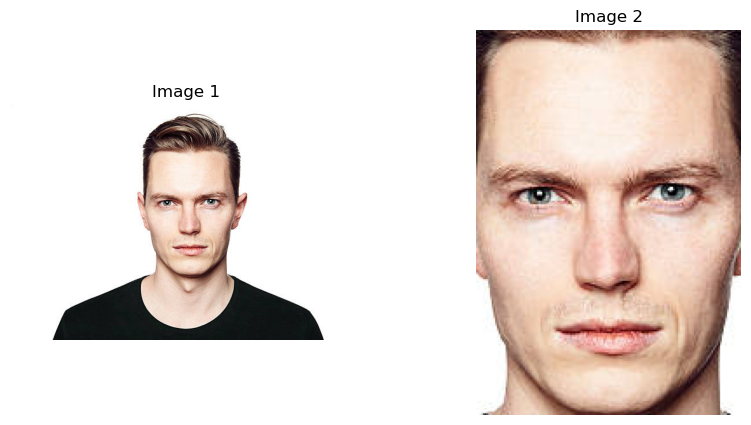

[-0.4023300111293793,
 -0.47048377990722656,
 -0.7550680041313171,
 -0.7333694696426392,
 1.161057472229004,
 -0.7454827427864075,
 0.7221633791923523,
 1.006057620048523,
 0.40603718161582947,
 0.9551807045936584,
 -0.8851029872894287,
 1.4885934591293335,
 -1.0753129720687866,
 0.23205164074897766,
 -1.685849666595459,
 -0.2219889760017395,
 0.41816246509552,
 0.4097921848297119,
 -1.276734709739685,
 0.2246505469083786,
 0.3602006435394287,
 1.2469956874847412,
 0.6940031051635742,
 0.3017559051513672,
 -0.49124640226364136,
 -0.5236169099807739,
 0.16590960323810577,
 0.1753123700618744,
 0.19020496308803558,
 0.04052307829260826,
 -0.4756321907043457,
 -0.5440778732299805,
 0.7966081500053406,
 -1.6207656860351562,
 -0.3465925455093384,
 0.046635113656520844,
 0.7596681714057922,
 -0.7632650136947632,
 1.0718994140625,
 -0.47344526648521423,
 -0.6234742999076843,
 0.8998882174491882,
 0.09124709665775299,
 0.8604604601860046,
 0.09118001908063889,
 0.379226952791214,
 -0.286841452

In [4]:
get_embeddings(facenet_client,image_path)

In [6]:
img ='gallery_faces/gallery_10_2.jpg'
img_postv ='gallery_faces/gallery_10_1.jpg'
img_neg ='gallery_faces/gallery_20_1.jpg'

In [21]:
embeddings   = get_embeddings(facenet_client, img)
embeddings_p = get_embeddings(facenet_client, img_postv)
embeddings_n = get_embeddings(facenet_client, img_neg)


0: 640x480 2 FACEs, 13.8ms
Speed: 3.8ms preprocess, 13.8ms inference, 2.6ms postprocess per image at shape (1, 3, 640, 480)

0: 640x448 1 FACE, 14.2ms
Speed: 2.6ms preprocess, 14.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 448)

0: 640x480 1 FACE, 14.9ms
Speed: 3.4ms preprocess, 14.9ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 480)


Metric: euclidean
  Verified: True
  Distance: 13.430268919800298
  Threshold: 23.56

Metric: cosine
  Verified: True
  Distance: 0.2282540320595673
  Threshold: 0.3

Metric: euclidean_l2
  Verified: True
  Distance: 0.6756538049320336
  Threshold: 1.04



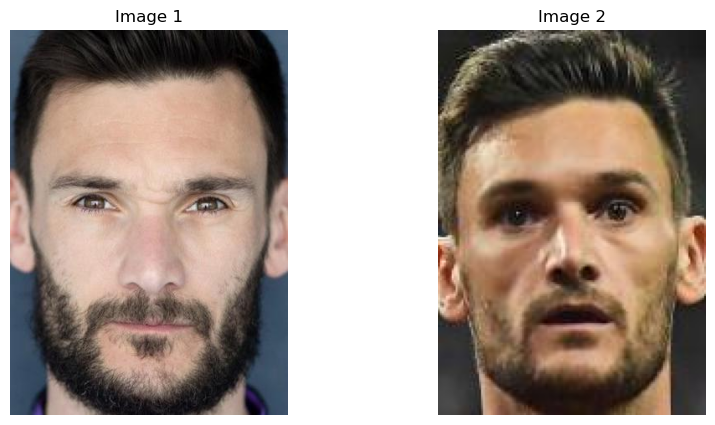

Metric: euclidean
  Verified: False
  Distance: 26.735482747957228
  Threshold: 23.56

Metric: cosine
  Verified: False
  Distance: 0.8423330894311929
  Threshold: 0.3

Metric: euclidean_l2
  Verified: False
  Distance: 1.2979469091077591
  Threshold: 1.04



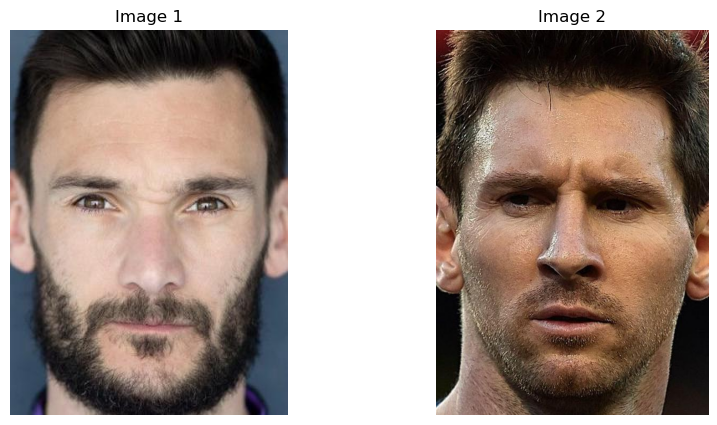

In [24]:
FaceVerifier().verify_faces(embeddings, embeddings_p, verbose=True)
plot_images(img, img_postv)
FaceVerifier().verify_faces(embeddings, embeddings_n, verbose=True)
plot_images(img, img_neg)

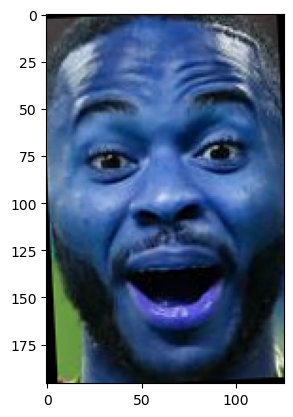

In [ ]:
# Example usage
face_aligner = FaceAligner()
aligned_face = face_aligner.align_face(image, min_face_size=70)
if aligned_face is not None:
    plt.imshow(aligned_face)


else:
    print("Could not detect eyes in the image")

In [6]:
import tensorflow as tf
import numpy as np
import cv2

class FaceNetTFLiteClient:
    """
    FaceNet TFLite model class
    """

    def __init__(self, model_path: str):
        self.interpreter = tf.lite.Interpreter(model_path=model_path)
        self.interpreter.allocate_tensors()
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()
        print("Input details:", self.input_details)
        print("Output details:", self.output_details)
        self.input_shape = self.input_details[0]['shape'][1:3]  # (height, width)
        self.output_shape = self.output_details[0]['shape'][1]  # 512

    def preprocess_image(self, image: np.ndarray) -> np.ndarray:
        # Ensure the image is loaded correctly
        if image is None:
            raise ValueError("Image is not loaded correctly.")
        # Resize the image to the input shape of the model
        resized_image = cv2.resize(image, (self.input_shape[1], self.input_shape[0]))
        # Normalize the image
        normalized_image = resized_image
        # Expand dimensions to match the model's input shape (N, H, W, C)
        input_tensor = np.expand_dims(normalized_image, axis=0).astype(np.uint8)
        return input_tensor

    def forward(self, image: np.ndarray) -> np.ndarray:
        input_tensor = self.preprocess_image(image)
        self.interpreter.set_tensor(self.input_details[0]['index'], input_tensor)
        self.interpreter.invoke()
        output_data = self.interpreter.get_tensor(self.output_details[0]['index'])
        return output_data

    def postprocess(self, box_coords: np.ndarray, box_scores: np.ndarray, original_image_shape: tuple[int, int], score_threshold: float = 0.5) -> tuple[np.ndarray, np.ndarray]:
        # Dequantize the box coordinates
        scale, zero_point = self.output_details[0]['quantization']
        box_coords = (box_coords.astype(np.float32) - zero_point) * scale

        # Dequantize the box scores
        scale, zero_point = self.output_details[1]['quantization']
        box_scores = (box_scores.astype(np.float32) - zero_point) * scale

        # Filter boxes by score threshold
        mask = box_scores >= score_threshold
        box_coords = box_coords[mask]
        box_scores = box_scores[mask]

        # Scale bounding boxes to the original image size
        input_height, input_width = self.input_shape[0], self.input_shape[1]
        original_height, original_width = original_image_shape

        box_coords[:, [0, 2]] *= original_width  # Scale xmin and xmax
        box_coords[:, [1, 3]] *= original_height  # Scale ymin and ymax

        return box_coords, box_scores


In [7]:

# Example usage
if __name__ == '__main__':
    model_path = '/home/hatem/face_recognizer_container/Model/MediaPipeFaceDetector.tflite'
    image_path  ='gallery_faces/gallery_10_2.jpg'


    facenet_client = FaceNetTFLiteClient(model_path)
    image = cv2.imread(image_path)
    embeddings = facenet_client.forward(image)
    # boxcoords, boxscores = facenet_client.postprocess(box_coords, box_scores, original_image_shape=image.shape[:2])
    print(f"Embeddings: {embeddings}")

Input details: [{'name': 'image', 'index': 0, 'shape': array([  1, 256, 256,   3], dtype=int32), 'shape_signature': array([  1, 256, 256,   3], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (0.003921568859368563, 0), 'quantization_parameters': {'scales': array([  0.0039216], dtype=float32), 'zero_points': array([0], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
Output details: [{'name': 'box_coords', 'index': 267, 'shape': array([  1, 896,  16], dtype=int32), 'shape_signature': array([  1, 896,  16], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (1.9435529708862305, 127), 'quantization_parameters': {'scales': array([     1.9436], dtype=float32), 'zero_points': array([127], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}, {'name': 'box_scores', 'index': 264, 'shape': array([  1, 896,   1], dtype=int32), 'shape_signature': array([  1, 896,   1], dtype=int32), 'dtype': <class 'numpy.uint8'>, 'quantization': (1.0, 1

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [9]:
embeddings.shape

(1, 896, 16)

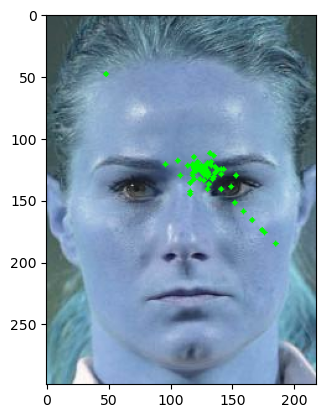

In [31]:
for x, y in keypoints[0][650].reshape(-1, 2):
    cv2.circle(img, (int(x), int(y)), 2, (0, 255, 0), -1)
plt.imshow(img)


In [39]:
output_details = interpreter.get_output_details()
output_details

[{'name': 'box_coords',
  'index': 267,
  'shape': array([  1, 896,  16], dtype=int32),
  'shape_signature': array([  1, 896,  16], dtype=int32),
  'dtype': numpy.uint8,
  'quantization': (1.9435529708862305, 127),
  'quantization_parameters': {'scales': array([1.943553], dtype=float32),
   'zero_points': array([127], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}},
 {'name': 'box_scores',
  'index': 264,
  'shape': array([  1, 896,   1], dtype=int32),
  'shape_signature': array([  1, 896,   1], dtype=int32),
  'dtype': numpy.uint8,
  'quantization': (1.0, 128),
  'quantization_parameters': {'scales': array([1.], dtype=float32),
   'zero_points': array([128], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]

In [26]:
input_details

[{'name': 'image',
  'index': 0,
  'shape': array([  1,   3, 128, 128], dtype=int32),
  'shape_signature': array([  1,   3, 128, 128], dtype=int32),
  'dtype': numpy.uint8,
  'quantization': (1.001164197921753, 0),
  'quantization_parameters': {'scales': array([1.0011642], dtype=float32),
   'zero_points': array([0], dtype=int32),
   'quantized_dimension': 0},
  'sparsity_parameters': {}}]